In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
IMG_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCH = 20

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "breast_cancer_mri",
    shuffle= True,
    image_size= (IMG_SIZE, IMG_SIZE),
    batch_size= BATCH_SIZE
)

Found 780 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['benign', 'malignant', 'normal']

In [5]:
len(dataset)

25

training data = 80% ; validation data = 10% ; testing data = 10%


In [6]:
def dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = dataset_partition(dataset)

In [8]:
len(train_ds)

20

In [9]:
len(val_ds)

2

In [10]:
len(test_ds)

3

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])


In [13]:
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    #data_augmentation,
    
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size= (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size= (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    train_ds,
    epochs=EPOCH,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
20/20 [==============================] - 27s 1s/step - loss: 1.0157 - accuracy: 0.5435 - val_loss: 0.9615 - val_accuracy: 0.6250
Epoch 2/20
20/20 [==============================] - 20s 1s/step - loss: 0.9761 - accuracy: 0.5435 - val_loss: 0.8459 - val_accuracy: 0.6250
Epoch 3/20
20/20 [==============================] - 20s 1s/step - loss: 0.9412 - accuracy: 0.5452 - val_loss: 0.7793 - val_accuracy: 0.6250
Epoch 4/20
20/20 [==============================] - 20s 1s/step - loss: 0.8710 - accuracy: 0.5968 - val_loss: 0.7462 - val_accuracy: 0.6562
Epoch 5/20
20/20 [==============================] - 20s 1s/step - loss: 0.8459 - accuracy: 0.6161 - val_loss: 0.7378 - val_accuracy: 0.6250
Epoch 6/20
20/20 [==============================] - 20s 1s/step - loss: 0.8274 - accuracy: 0.6194 - val_loss: 0.6789 - val_accuracy: 0.7031
Epoch 7/20
20/20 [==============================] - 20s 1s/step - loss: 0.7657 - accuracy: 0.6403 - val_loss: 0.6695 - val_accuracy: 0.7031
Epoch 8/20
20/20 [==

In [16]:
score = model.evaluate(test_ds)

3/3 [==============================] - 2s 243ms/step - loss: 0.1935 - accuracy: 0.9375


In [17]:
score

[0.19346670806407928, 0.9375]

In [18]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 20}

In [19]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [21]:
import matplotlib.pyplot as plt

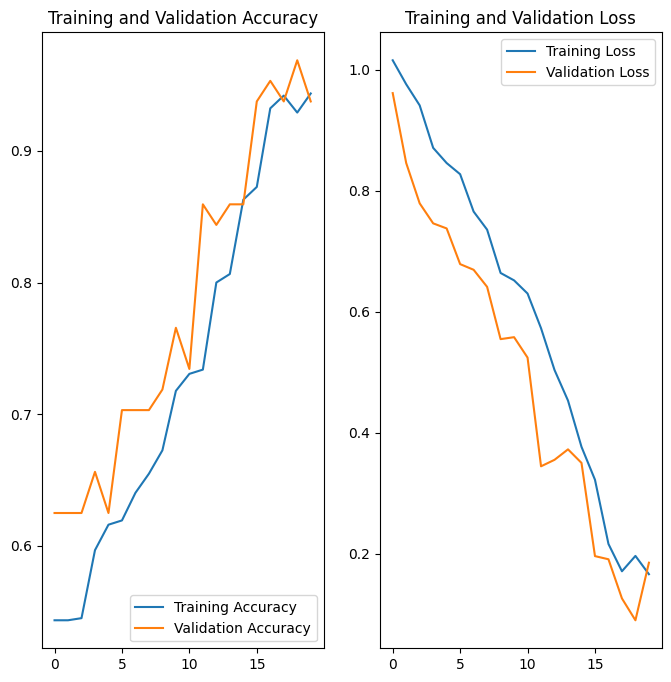

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCH), acc, label='Training Accuracy')
plt.plot(range(EPOCH), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCH), loss, label='Training Loss')
plt.plot(range(EPOCH), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
model_version = "bc_mri_cnn"
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/bc_mri_cnn\assets
